In [6]:
import pandas as pd
from datetime import datetime as dt, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors 

In [9]:
df = pd.read_csv('online_retail.csv')

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [20]:
## Finiding each customers RFM Values

# Recency

# Define the reference date as a Timestamp
day = pd.to_datetime('2012-01-01')

# Convert InvoiceDate column to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Recency
recency = df.groupby("CustomerID").agg({"InvoiceDate": lambda x: (day - x.max()).days})

# Rename the column for clarity
recency.rename(columns={"InvoiceDate": "Recency"}, inplace=True)

print(recency.head(3))







            Recency
CustomerID         
12346.0         347
12347.0          24
12348.0          97


In [22]:
# Frequency

freq=df.drop_duplicates(subset="InvoiceNo").groupby(["CustomerID"])[["InvoiceNo"]].count()
freq.head()

,InvoiceNo
CustomerID,
12346.0,2
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [24]:
#  Monetary Value

df["total"]=df["UnitPrice"]*df["Quantity"]
money = df.groupby(["CustomerID"])[["total"]].sum()
money.head()

,total
CustomerID,
12346.0,0.00
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


In [29]:
RFM = pd.concat([recency,freq,money],axis=1)
recency.columns=["Recency"]
freq.columns=["Frequency"]
money.columns=["Monetary"]

In [30]:
RFM

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,347,2,0.00
12347.0,24,7,4310.00
12348.0,97,4,1797.24
12349.0,40,1,1757.55
12350.0,332,1,334.40
...,...,...,...
18280.0,299,1,180.60
18281.0,202,1,80.82
18282.0,29,3,176.60


In [31]:
## Standarize the dataset to form a common scale to help the machine learning model

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaled=scaler.fit_transform(RFM)

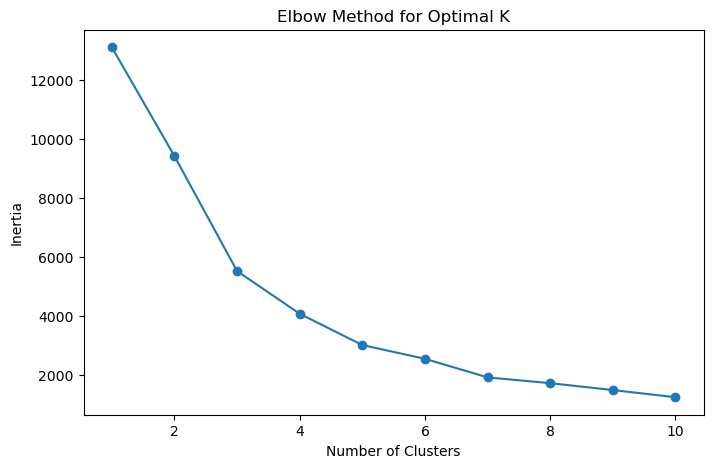

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming `scaled` is your scaled dataset
inertia = []
for i in np.arange(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker="o")  # Correct marker style
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


# since the elbow is between 2 and 4 I would asssumen number of cluster is 3

In [42]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled)
RFM["Clusters"]=(kmeans.labels_ +1)

RFM

,Recency,Frequency,Monetary,Clusters
CustomerID,,,,
12346.0,347,2,0.00,2
12347.0,24,7,4310.00,1
12348.0,97,4,1797.24,1
12349.0,40,1,1757.55,1
12350.0,332,1,334.40,2
...,...,...,...,...
18280.0,299,1,180.60,2
18281.0,202,1,80.82,2
18282.0,29,3,176.60,1


In [45]:
group = RFM.groupby("Clusters")[["Recency", "Frequency", "Monetary"]].mean()
print(group)


             Recency  Frequency      Monetary
Clusters                                     
1          61.593084   5.548626   1795.309282
2         267.719964   1.852755    460.644066
3          27.346154  83.346154  75966.387308


In [46]:
def func(row):
    if row["Clusters"] == 1:
        return "Avg Cx"
    elif row["Clusters"] == 3:
        return "Whales Cx"
    else:
        return "Lapsed Cx"

In [55]:
RFM["Condition"] = RFM.apply(func,axis=1)
RFM

,Recency,Frequency,Monetary,Clusters,Condition
CustomerID,,,,,
12346.0,347,2,0.00,2,Lapsed Cx
12347.0,24,7,4310.00,1,Avg Cx
12348.0,97,4,1797.24,1,Avg Cx
12349.0,40,1,1757.55,1,Avg Cx
12350.0,332,1,334.40,2,Lapsed Cx
...,...,...,...,...,...
18280.0,299,1,180.60,2,Lapsed Cx
18281.0,202,1,80.82,2,Lapsed Cx
18282.0,29,3,176.60,1,Avg Cx


In [57]:
result = RFM["Condition"].value_counts()
result

Condition
Avg Cx       3239
Lapsed Cx    1107
Whales Cx      26
Name: count, dtype: int64

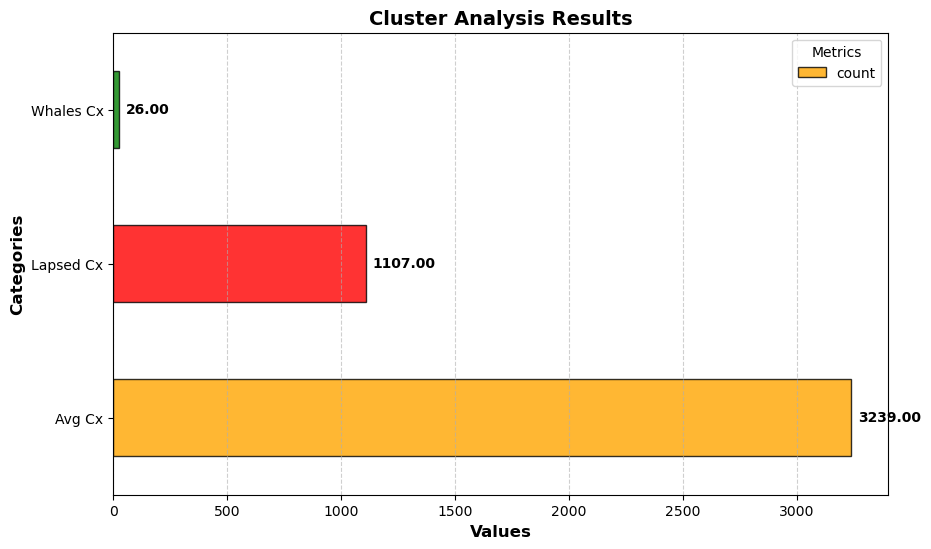

In [60]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Plot horizontal bar chart with custom colors
ax = result.plot(kind='barh', color=["orange", "red", "green"], edgecolor='black', alpha=0.8)

# Add labels to each bar
for bars in ax.containers:
    ax.bar_label(bars, fmt="%.2f", padding=5, fontsize=10, fontweight='bold')

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Set labels and title
plt.xlabel("Values", fontsize=12, fontweight='bold')
plt.ylabel("Categories", fontsize=12, fontweight='bold')
plt.title("Cluster Analysis Results", fontsize=14, fontweight='bold')

# Add a legend (if multiple columns exist in `result`)
plt.legend(title="Metrics", fontsize=10)

# Display the plot
plt.show()
